# Experiment 4: Image classification using Convolution Neural Network

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

data_dir = pathlib.Path(data_dir)

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [7]:
print(image_count)

3670


### Roses:

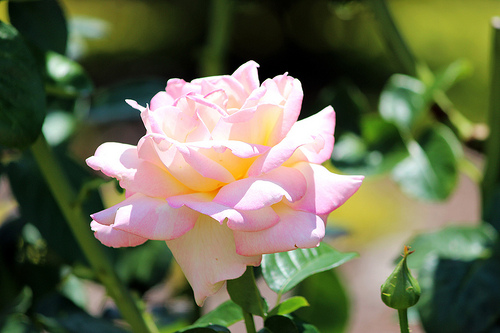

In [65]:
roses = list(data_dir.glob('roses/*'))

PIL.Image.open(str(roses[65]))

### Tulips:

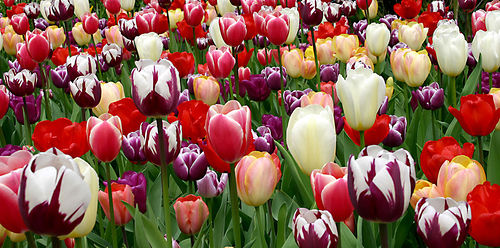

In [53]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[27]))

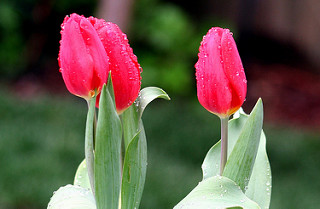

In [69]:
PIL.Image.open(str(tulips[0]))

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory( data_dir, validation_split=0.2, subset="training",
  seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory( data_dir, validation_split=0.2, subset="validation", seed=123,\
  image_size=(img_height, img_width), batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


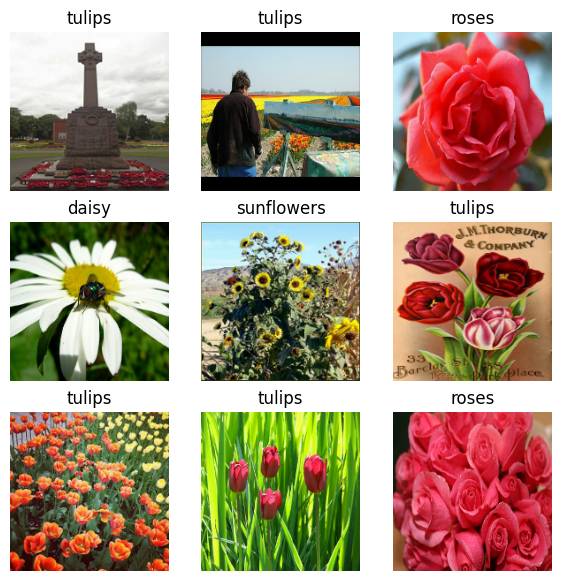

In [38]:
# Visualizing the Data
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Feature Scaling (Standardizing the data)

In [23]:
# The RGB channel values are in the `[0, 255]` range. 
# We will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:
normalization_layer = layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99782133


In [25]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [1]:
# model.summary()

### Train the model

In [ ]:
history = model.fit( train_ds, validation_data=val_ds, epochs=10, verbose = False)

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

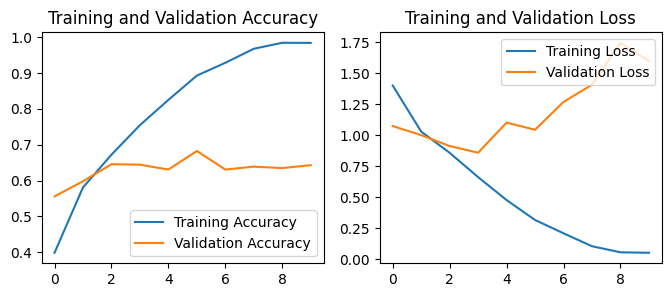

In [35]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation and Dropout to avoid Overfitting

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(), 
  layers.Dropout(0.2), layers.Flatten(),
  layers.Dense(128, activation='relu'), layers.Dense(num_classes, name="outputs")
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [59]:
# Fitting the Model with train and Validation Data
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  verbose = False
)

## Predict on new data

In [58]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent Accuracy."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to sunflowers with a 99.74 percent Accuracy.
